# Geomorphological Characteristics

Following the watershed delineation in previous notebook [8_waterhsed_delineation](notebooks/preprocessing/8_waterhsed_delineation.ipynb), a comprehensive suite of geomorphological parameters, as identified for this study (e.g., Area, Basin Length, Drainage Density, Relief Ratio, Form Factor, etc.), will be systematically derived for each delineated watershed using the DEM and the delineated boundaries. These quantitative descriptors of basin physiography are essential outputs of this notebook, forming the independent variables dataset that will be used to train the machine learning models for predicting ModClark parameters ($T_c$ and $R$).

In [81]:
import importlib
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
from plotnine import *
import random
from tqdm.notebook import tqdm
from shapely.geometry import MultiPolygon, Polygon
import importlib
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gc
import rasterio
import warnings

In [2]:
# Set paths
project_root_path = Path.cwd().parent.parent
wsdir = project_root_path / 'data/silver/geo/gpkg/watersheds'

In [3]:
# Custom Modules
sys.path.append(str(project_root_path / 'src'))
import preprocessing.compute_geomorphological_cha as gmc

In [82]:
# Supress warnings
warnings.filterwarnings("ignore")


## Exploratory Data Analysis

In [4]:
ws_file_path = list(wsdir.glob('*.gpkg'))
print(f'Number of delineated watersheds: {len(ws_file_path)}')

Number of delineated watersheds: 690


In [42]:
# Analysis delineated watersheds
ws_df = pd.DataFrame()
# Read all watersheds
for ws_path in tqdm(ws_file_path, desc='Reading watersheds'):
    gdf = gpd.read_file(ws_path)
    keep_columns = ['stnid', 'area', 'distance_between_points_m',]
    df = gdf[keep_columns]

    ws_df = pd.concat([ws_df, df], ignore_index=True)
    
ws_df.head()


Reading watersheds:   0%|          | 0/690 [00:00<?, ?it/s]

,stnid,area,distance_between_points_m
0,03314000,96.740342,19.884212
1,03431060,14.758231,19.955516
2,03083500,36.482751,97.648123
3,03072000,1.826379,61.664518
4,03400785,1.563727,2259.562650


In [43]:
ws_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   stnid                      690 non-null    object 
 1   area                       690 non-null    float64
 2   distance_between_points_m  690 non-null    float64
dtypes: float64(2), object(1)
memory usage: 16.3+ KB


In [44]:
# Frequency table for distance_between_points_m
distance_bins = [0, 20, 100, 500, 1000, float('inf')]
distance_labels = ['0-20m', '21-100m', '101-500m', '501-1000m', '>1000m']

ws_df['distance_category'] = pd.cut(
    ws_df['distance_between_points_m'],
    bins=distance_bins,
    labels=distance_labels,
    right=True,
    include_lowest=True
)

distance_freq = ws_df['distance_category'].value_counts().sort_index()

print("Frequency Table for Distance Between Points (m):")
print(distance_freq)


Frequency Table for Distance Between Points (m):
distance_category
0-20m        214
21-100m      174
101-500m     141
501-1000m     36
>1000m       125
Name: count, dtype: int64


In [45]:

# Frequency table for area
area_bins = [0, 1.8, 5, 10, 20, 50, 80, float('inf')]
area_labels = ['<1.8 km²', '1.8-5 km²', '5.1-10 km²', '10.1-20 km²', '20.1-50 km²', '50.1-80 km²', '>80 km²']

ws_df['area_category'] = pd.cut(
    ws_df['area'],
    bins=area_bins,
    labels=area_labels,
    right=True,
    include_lowest=True
)

area_freq = ws_df['area_category'].value_counts().sort_index()

print("\nFrequency Table for Area (km²):")
print(area_freq)



Frequency Table for Area (km²):
area_category
<1.8 km²       248
1.8-5 km²      132
5.1-10 km²      64
10.1-20 km²     53
20.1-50 km²     72
50.1-80 km²     48
>80 km²         73
Name: count, dtype: int64


In [46]:
# Convert area frequency to DataFrame
area_freq_df = ws_df['area_category'].value_counts().sort_index().reset_index()
area_freq_df.columns = ['area_category', 'count']

# Convert distance frequency to DataFrame
distance_freq_df = ws_df['distance_category'].value_counts().sort_index().reset_index()
distance_freq_df.columns = ['distance_category', 'count']

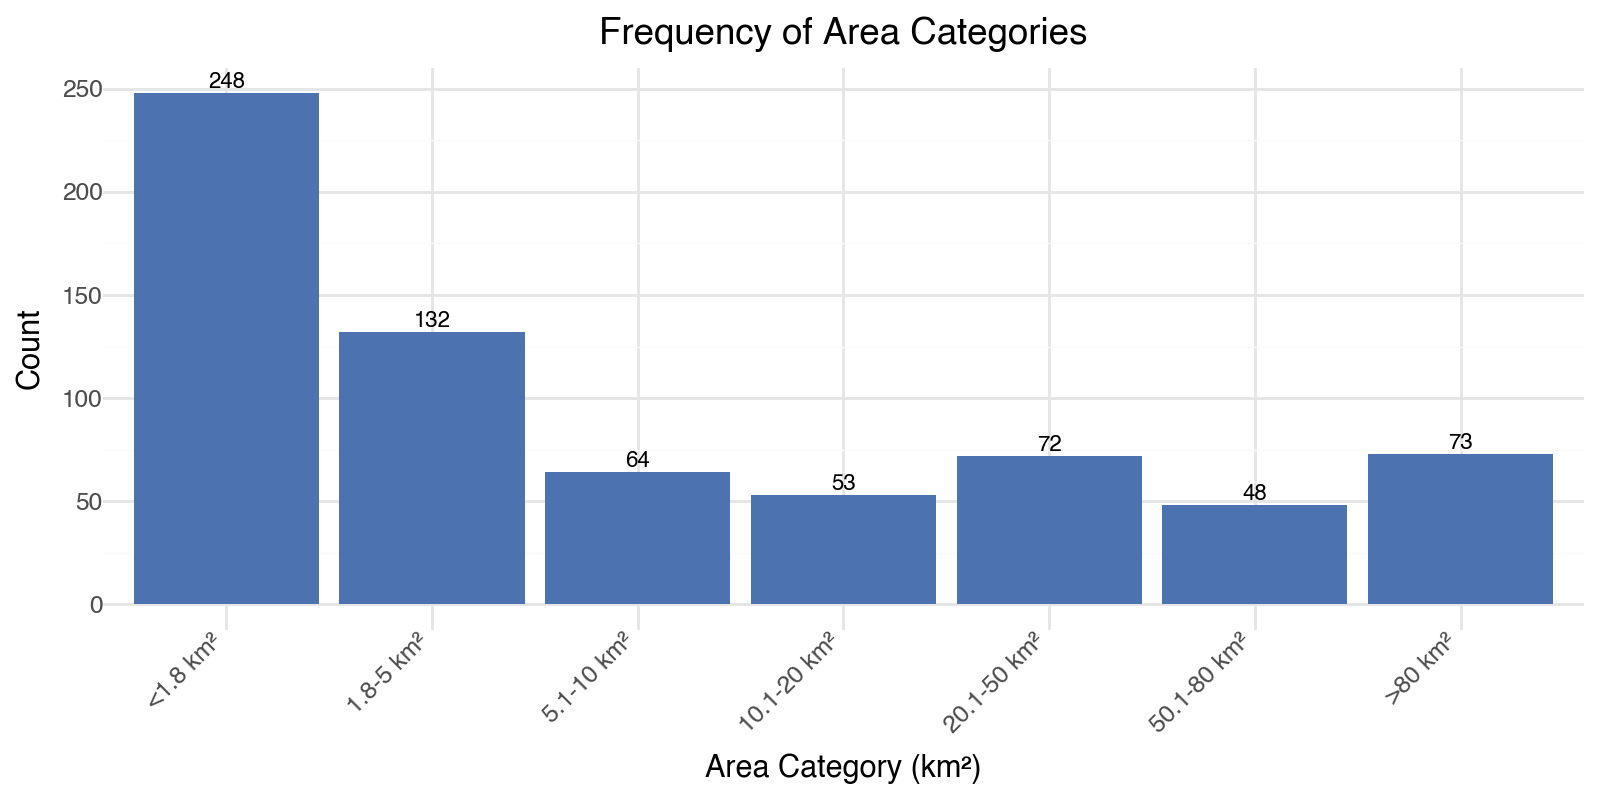

In [47]:
area_plot = (
    ggplot(area_freq_df, aes(x='area_category', y='count')) +
    geom_bar(stat='identity', fill="#4C72B0") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Area Categories',
        x='Area Category (km²)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

area_plot.show()


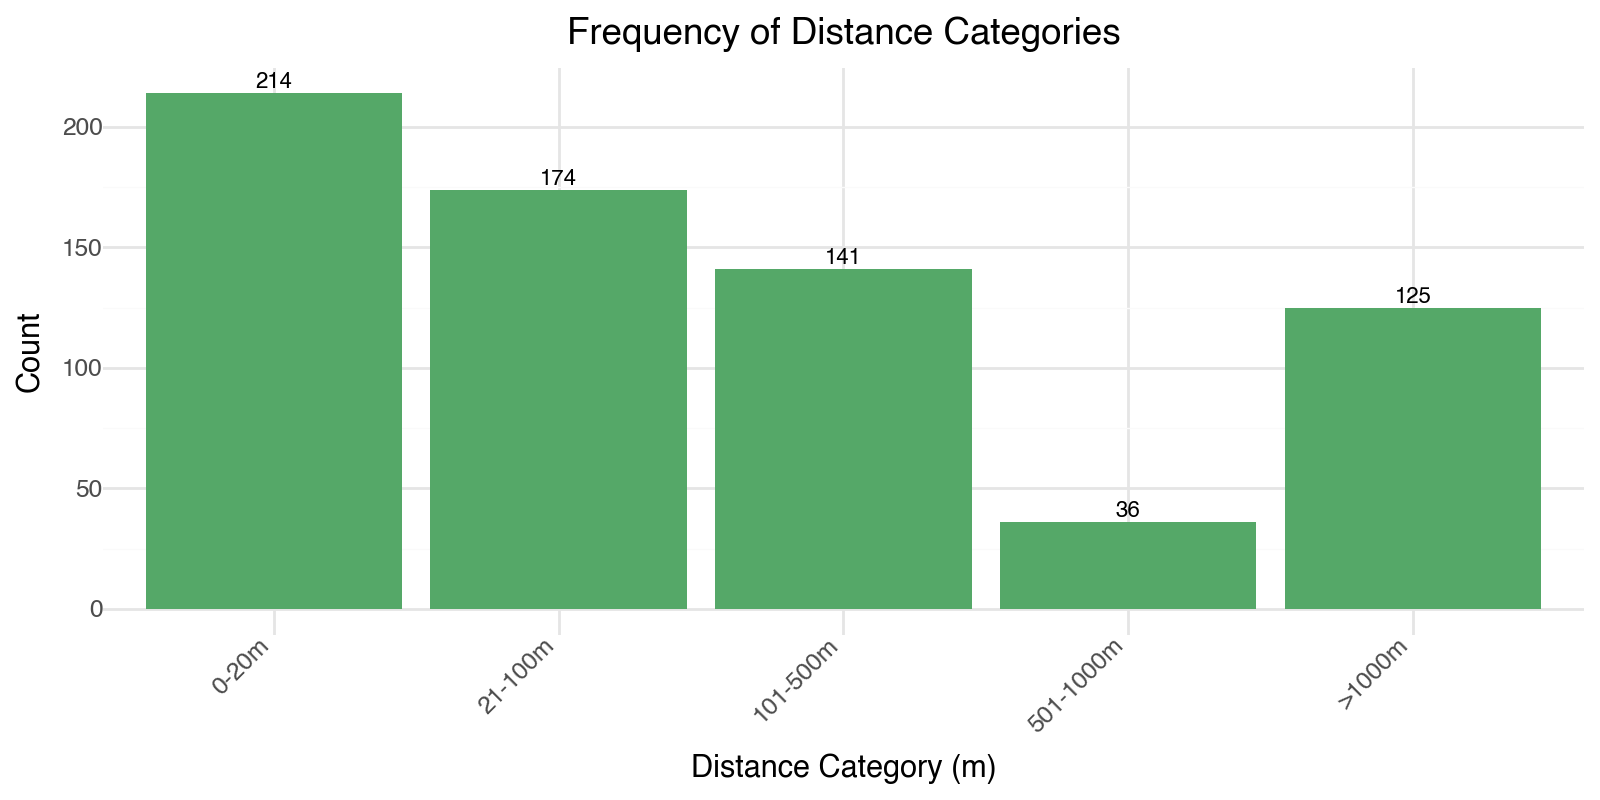

In [48]:
distance_plot = (
    ggplot(distance_freq_df, aes(x='distance_category', y='count')) +
    geom_bar(stat='identity', fill="#55A868") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Distance Categories',
        x='Distance Category (m)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

distance_plot.show()


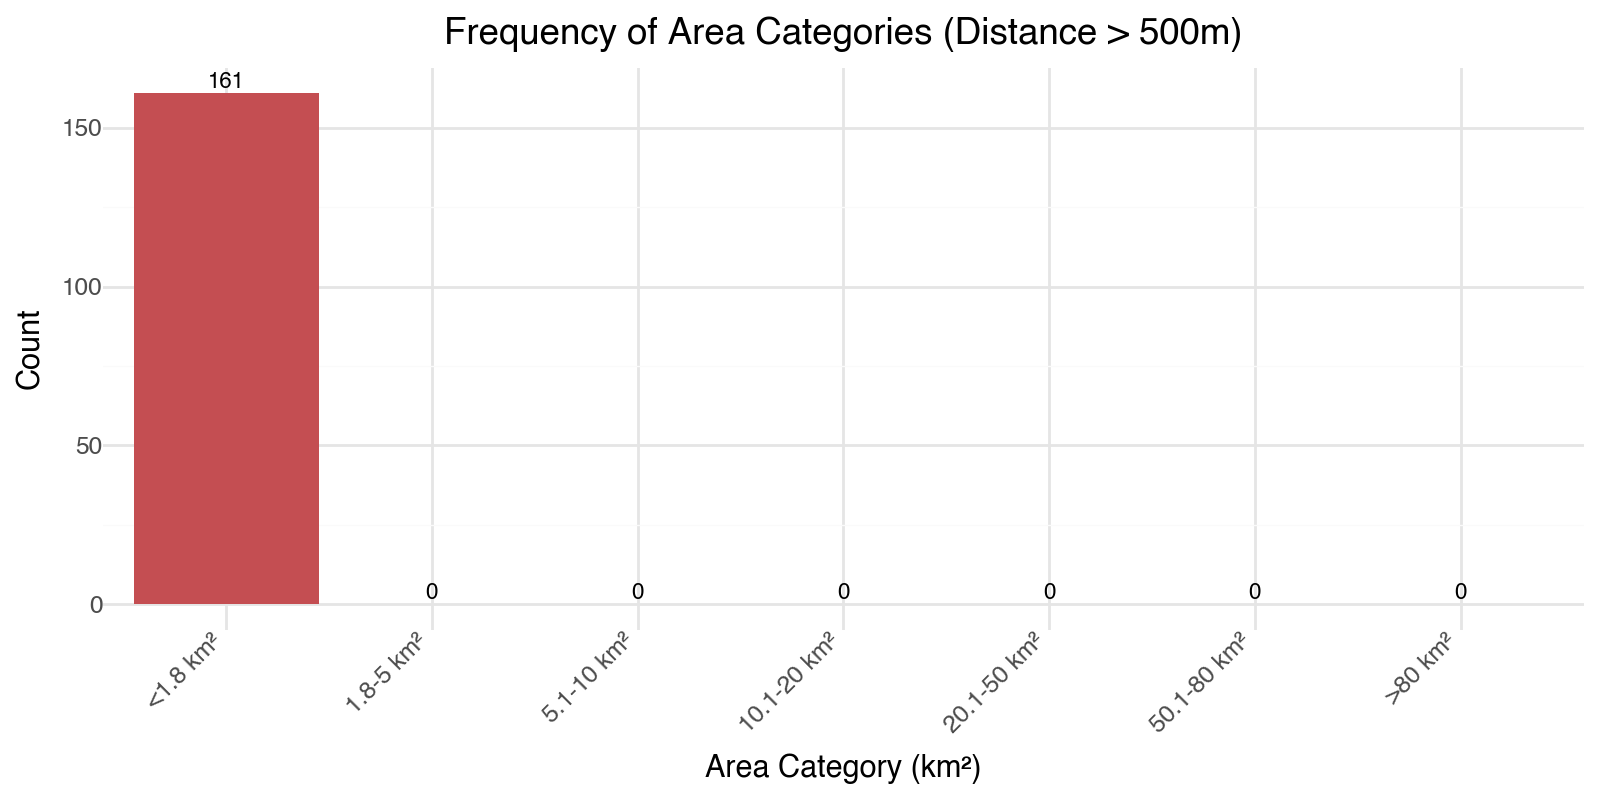

In [49]:
filtered_df = ws_df[ws_df['distance_between_points_m'] > 500]
filtered_area_freq_df = filtered_df['area_category'].value_counts().sort_index().reset_index()
filtered_area_freq_df.columns = ['area_category', 'count']

filtered_area_plot = (
    ggplot(filtered_area_freq_df, aes(x='area_category', y='count')) +
    geom_bar(stat='identity', fill="#C44E52") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Area Categories (Distance > 500m)',
        x='Area Category (km²)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

filtered_area_plot.show()


From above, distance decreases when increasing area. It makes sense, because greater watershed area will have higher accumulation ceel value on outlet being easier to spot. Also greater area better disolves noisy data. 

Still froma above all delineation that faield on distance criteria, also failed on the area creteria. 

The procedure is to drop those stations. 

### Drop Failed Stations

In [50]:
# Drop failed stations
valid_wsb = ws_df[ws_df['distance_between_points_m']<=500]
print(f'Number of valid watersheds: {len(valid_wsb)}')
valid_wsb.head()

Number of valid watersheds: 529


,stnid,area,distance_between_points_m,distance_category,area_category
0,03314000,96.740342,19.884212,0-20m,>80 km²
1,03431060,14.758231,19.955516,0-20m,10.1-20 km²
2,03083500,36.482751,97.648123,21-100m,20.1-50 km²
3,03072000,1.826379,61.664518,21-100m,1.8-5 km²
5,400150083053401,1.686070,407.426810,101-500m,<1.8 km²


In [51]:
valid_wsb_path = project_root_path / 'data/silver/tabular/other/valid_watersheds.csv'
valid_wsb_path.parent.mkdir(parents=True, exist_ok=True)
valid_wsb.to_csv(valid_wsb_path, index=False)

A total of **529** Valid stations will proceed to parameters modelings.

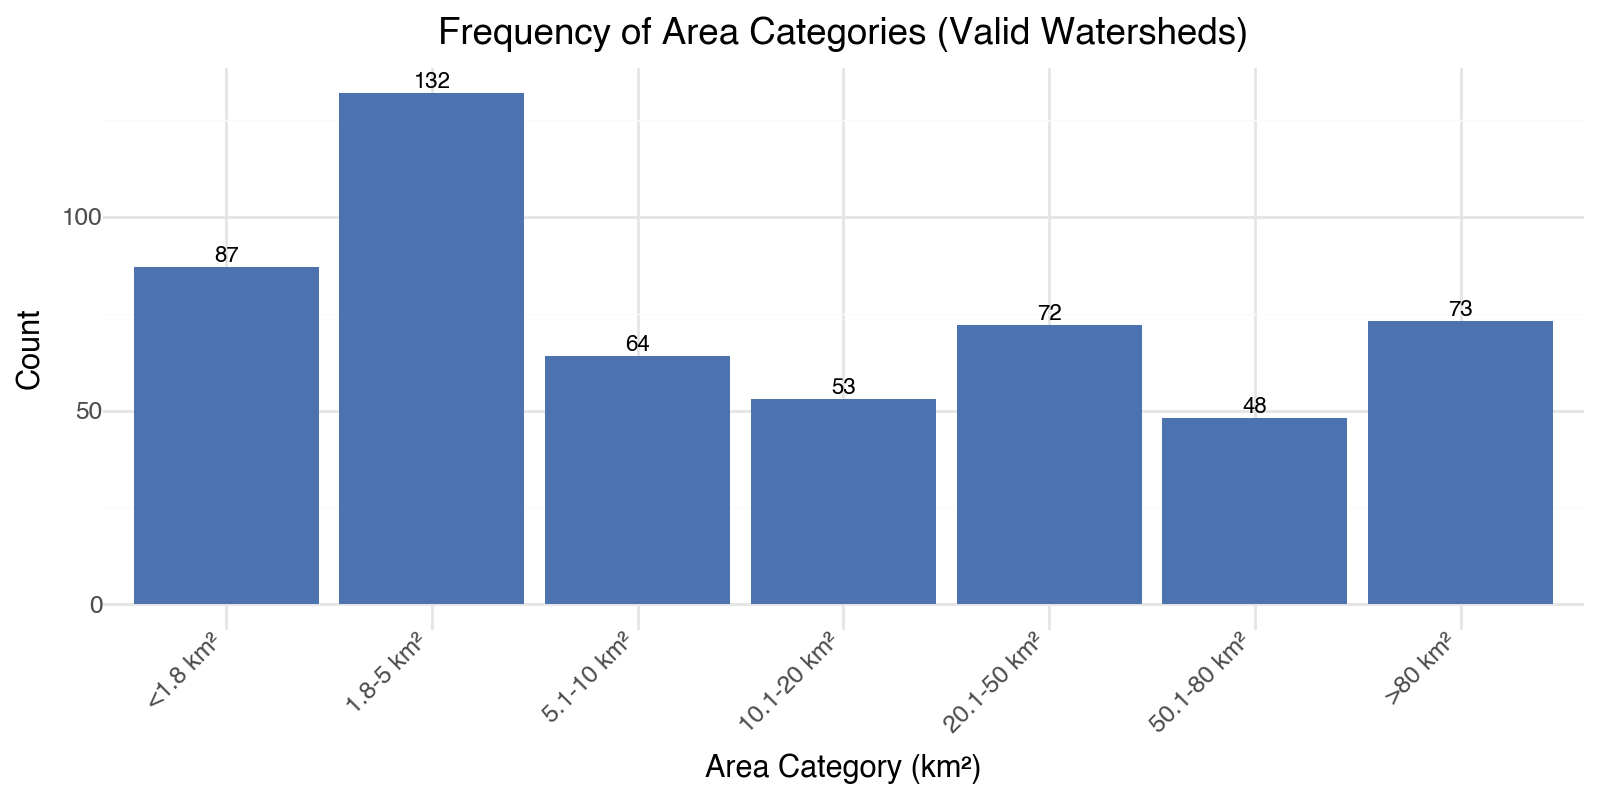

In [21]:
valid_wsb_freq = valid_wsb['area_category'].value_counts().sort_index().reset_index()
valid_wsb_freq.columns = ['area_category', 'count']

area_plot = (
    ggplot(valid_wsb_freq, aes(x='area_category', y='count')) +
    geom_bar(stat='identity', fill="#4C72B0") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Area Categories (Valid Watersheds)',
        x='Area Category (km²)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

area_plot.show()

Still **87** station with smaller than 1.8km² remains on data. Lets take a look at their distances.

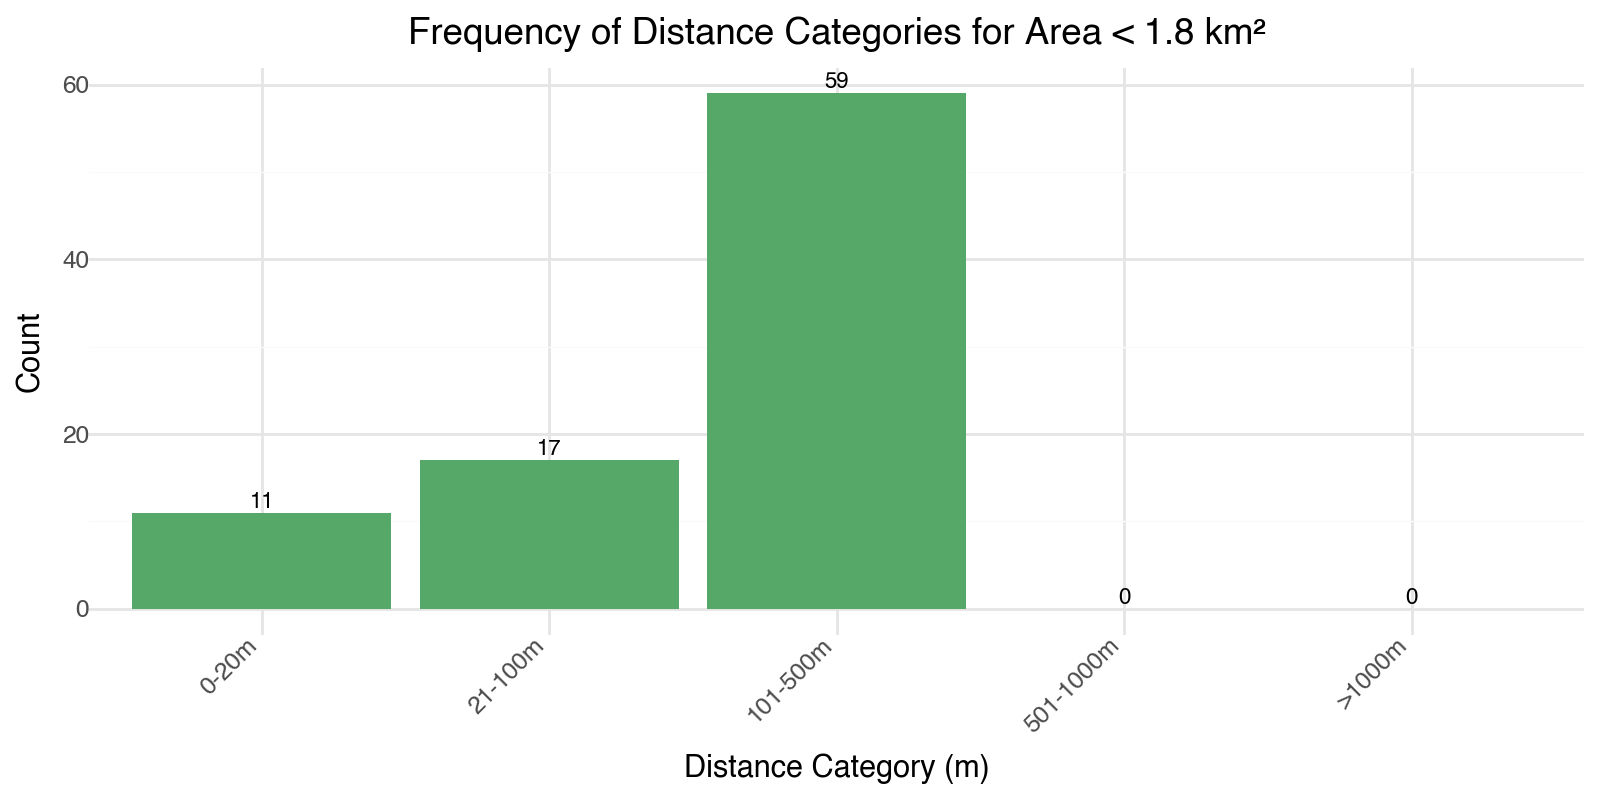

In [22]:
small_areas_df = valid_wsb[valid_wsb['area'] < 1.8]
small_areas_freq_df = small_areas_df['distance_category'].value_counts().sort_index().reset_index()
small_areas_freq_df.columns = ['distance_category', 'count']
distance_plot = (
    ggplot(small_areas_freq_df, aes(x='distance_category', y='count')) +
    geom_bar(stat='identity', fill="#55A868") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Distance Categories for Area < 1.8 km²',
        x='Distance Category (m)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

distance_plot.show()


In [23]:
small_areas_df['distance_category'].unique()

['101-500m', '0-20m', '21-100m']
Categories (5, object): ['0-20m' < '21-100m' < '101-500m' < '501-1000m' < '>1000m']

The most of remaing small area watersheds, have distance between original pour point and snapped pour point greater than 100. Those watersheds will be kept in the optmization process and analysed before including them in the machine learning models. If they result in outlier in the optmization process, they will be dropped from further analysis. 

## Dataset Cleaning

Before proceeding to computing geomorphological characteristics, a cleaning process will be perfomed, to remove interior polygons (holes).

Multi-Resolution Land Cover Data, will also be cleaned on this step. 

##### Remove Inner Rings (holes)

In [26]:
ws_file_path = list(wsdir.glob('*.gpkg'))

In [27]:
# Load style configuration for maps
map_style_path = project_root_path / 'config' / 'map_style.json'
with open(map_style_path, 'r') as f:
    map_style = json.load(f).get('map_styles',[])
    
wsb_style = map_style.get('watershed_boundary')


In [28]:
# Function to print watershed boundary and information
def create_watershed_map(ws_gdf, wsb_style):
    
    # Extract pour point and snapped pour point from string to geometry (in NAD83, EPSG:4269)
    ws_gdf['pour_point_geom'] = gpd.GeoSeries.from_wkt(ws_gdf['pour_point_nad83'], crs='EPSG:4269')
    ws_gdf['snapped_pour_point_geom'] = gpd.GeoSeries.from_wkt(ws_gdf['snapped_pour_point_nad83'], crs='EPSG:4269')
    
    # Project pour points to the CRS of ws_gdf
    pour_points = gpd.GeoDataFrame(
        {
            'geometry': [ws_gdf['pour_point_geom'].iloc[0], ws_gdf['snapped_pour_point_geom'].iloc[0]],
            'point_type': ['Pour Point', 'Snapped Pour Point']
        },
        crs='EPSG:4269'
    )
    pour_points = pour_points.to_crs(ws_gdf.crs)
    
    # Prepare text annotation for area and distance
    area = ws_gdf['area'].iloc[0]
    distance = ws_gdf['distance_between_points_m'].iloc[0]
    annotation_text = f"Area: {area:.2f} km²\nDistance: {distance:.2f} m"
    
    # Create the map
    wsb_map = (
        ggplot()
        + geom_map(
            mapping=aes(geometry='geometry'),
            data=ws_gdf,
            inherit_aes=False,
            color=wsb_style.get('color'),
            fill=None
        )
        + geom_point(
            mapping=aes(x=pour_points.geometry.x, y=pour_points.geometry.y, color='point_type'),
            data=pour_points,
            size=3,
            inherit_aes=False
        )
        + scale_color_manual(
            values={'Pour Point': 'red', 'Snapped Pour Point': 'blue'},
            name='Point Type'
        )
        + annotate(
            'text',
            x=float(ws_gdf.bounds.maxx.iloc[0] - 10),
            y=float(ws_gdf.bounds.maxy.iloc[0] - 10),
            label=annotation_text,
            size=10,
            ha='right',
            va='top'
        )
        + coord_fixed()
        + theme_minimal()
        + theme(
            legend_position='bottom',
            panel_grid_major=None,
            panel_grid_minor=None
        )
        + labs(
            title=f"Watershed boundary for station {ws_gdf.at[0, 'stnid']}",
            x="Easting",
            y="Northing"
        )
    )
    
    # Display the map
    wsb_map.show()

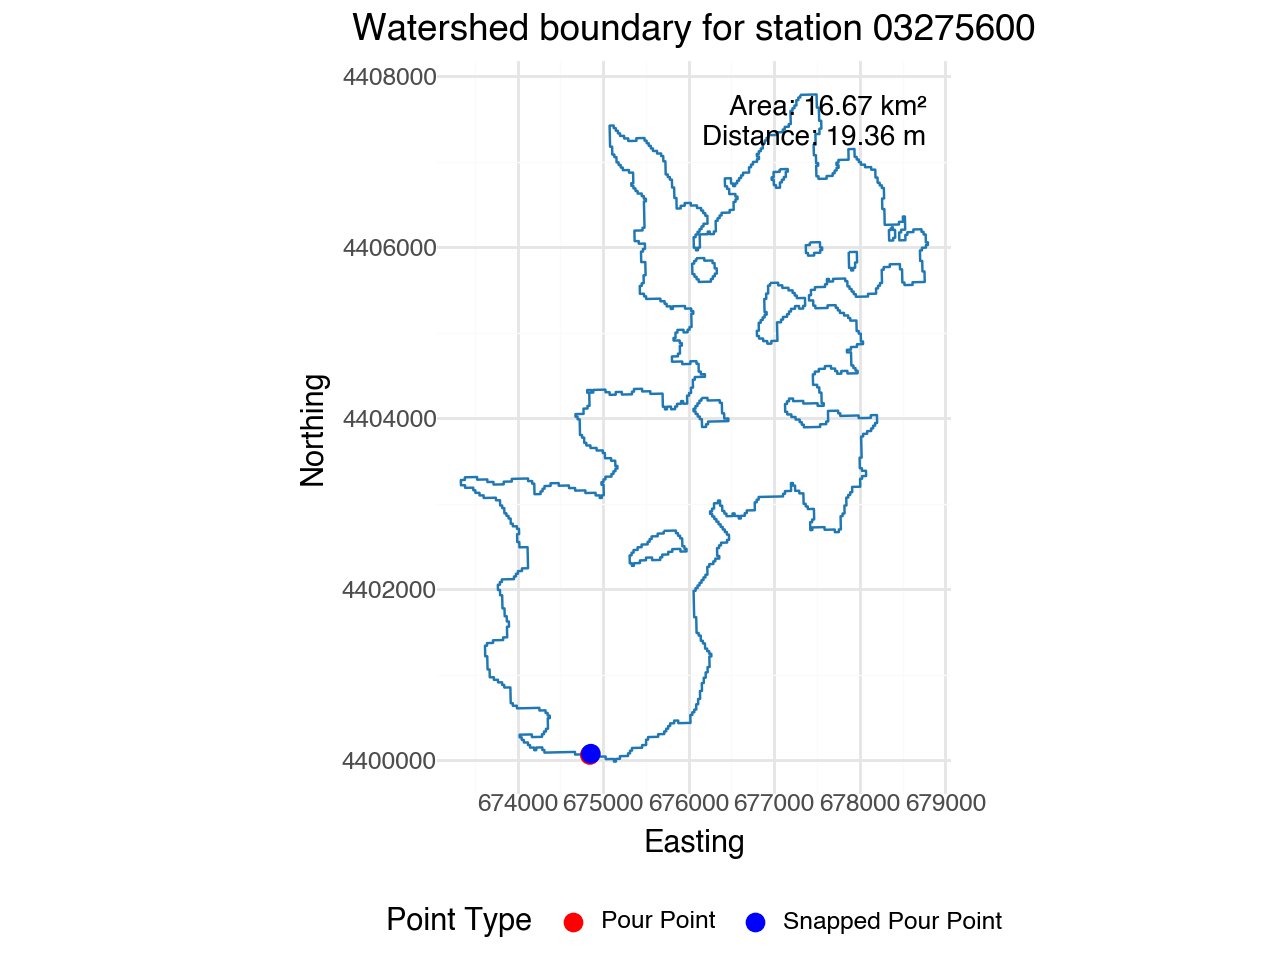

In [14]:
ws = gpd.read_file(ws_file_path[random.randint(0, len(ws_file_path)-1)])
create_watershed_map(ws, wsb_style)


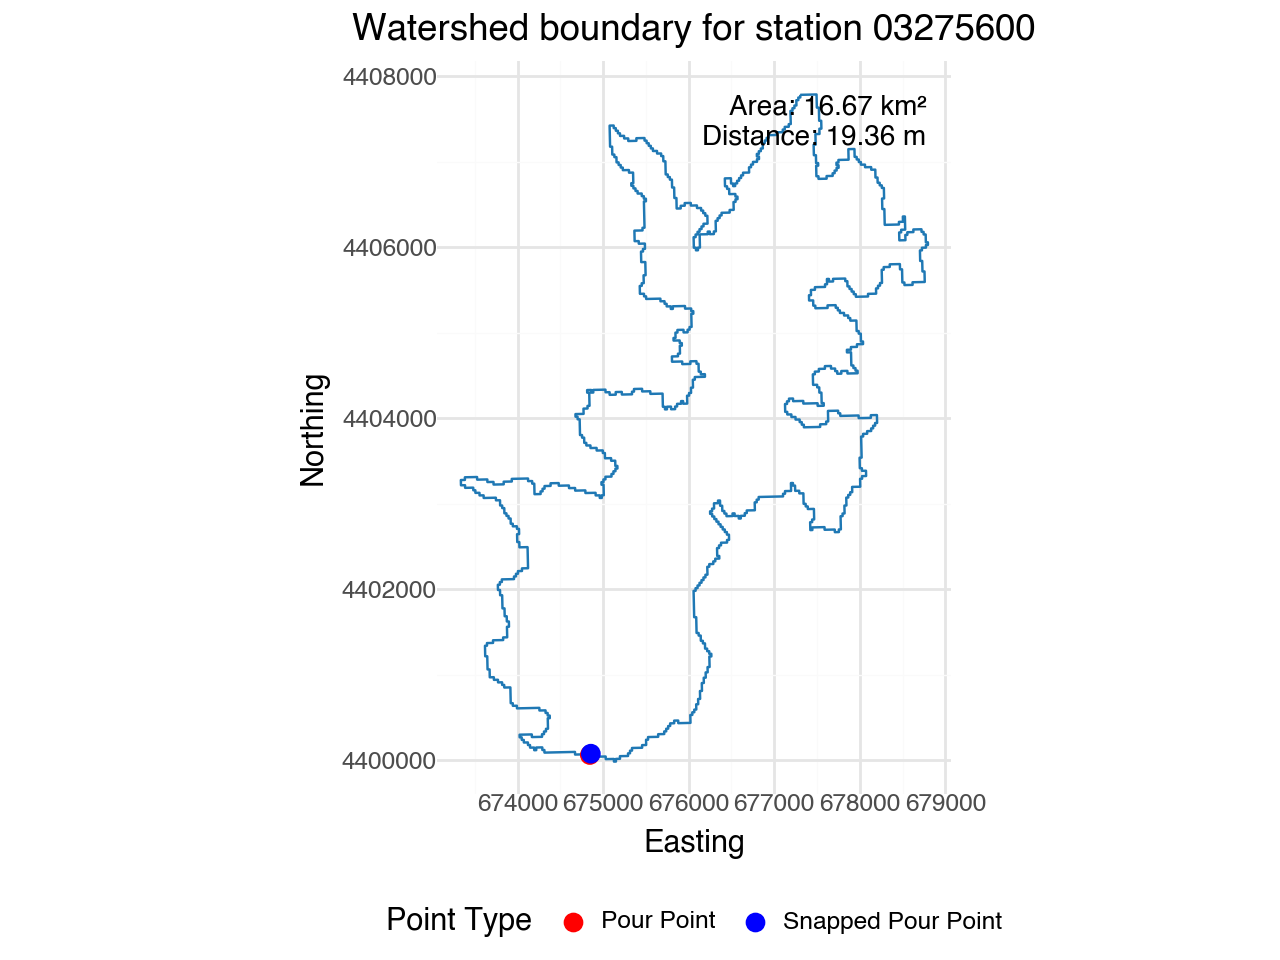

In [16]:
cleaned_ws = gmc.clean_watershed_gdf(ws)
create_watershed_map(cleaned_ws, wsb_style)

In [ ]:
# Batch process all watersheds
valid_wsb_path = project_root_path / 'data/silver/tabular/other/valid_watersheds.csv'
dtypes = {'stnid': 'object',
 'area': 'float64',
 'distance_between_points_m': 'float64',
 'distance_category': 'category',
 'area_category': 'category'}

valid_wsb = pd.read_csv(valid_wsb_path, dtype=dtypes)['stnid']
wsdir = project_root_path / 'data/silver/geo/gpkg/watersheds'
wsdir_out = project_root_path / 'data/gold/geo/gpkg/watersheds'
wsdir_out.mkdir(parents=True, exist_ok=True)

for stnid in tqdm(valid_wsb, desc='Processing watersheds'):
    ws_path = wsdir / f'catchment_{stnid}.gpkg'
    ws_out_path = wsdir_out / f'catchment_{stnid}.gpkg'

    if not ws_path.exists():
        print(f'Watershed file for {stnid} does not exist, skipping.')
        continue
    
    ws = gpd.read_file(ws_path)
    cleaned_ws = gmc.clean_watershed_gdf(ws)
    
    # Save cleaned watershed
    cleaned_ws.to_file(ws_out_path, driver='GPKG')



Processing watersheds:   0%|          | 0/529 [00:00<?, ?it/s]

In [64]:

valid_wsb.shape

(529,)

#### Clean MRLC Data

**Preprocessing Steps:**

1. Clip to Watershed Boundary:

- Use the watershed boundary to clip the MRLC raster to reduce computation and focus analysis on the area of interest.

2. Reproject to Consistent CRS:

- Ensure the MRLC raster shares the same Coordinate Reference System (CRS) as the DEM, flow direction raster, and other inputs.

3. Resample to DEM Resolution:

- Match the pixel size to your DEM resolution to ensure alignment during spatial analysis.

- Resampling method: nearest.

4. Mask to Remove NoData or Irrelevant Areas:

- Apply the watershed mask to ensure only relevant areas are considered.

5. Handle NoData values.
- Flag as unkown: 999

In [ ]:
# Find out dem resolution used to delineate the watershed
import rasterio
fdir_path = project_root_path / f'data/silver/geo/raster/watersheds/flowdir_{cleaned_ws['stnid'].iloc[0]}.tif'
with rasterio.open(fdir_path) as src:
    res  = src.res
    raster_crs = src.crs
print(f'DEM resolution: {res}. Dem CRS: {raster_crs}.')

DEM resolution: (0.0002777777778419781, 0.0002777777778204335). Dem CRS: EPSG:4269.


In [99]:
target_crs = cleaned_ws.crs
lonlat = cleaned_ws.to_crs(raster_crs).geometry.centroid
lon, lat = lonlat.x.iloc[0], lonlat.y.iloc[0]
print(f'Centroid of watershed in raster CRS: {lon}, {lat}.')

Centroid of watershed in raster CRS: -84.94455339812261, 39.76537566822604.


/var/folders/6x/tz4_svyx1mv9mc68z3jl0_s00000gn/T/ipykernel_1865/3495975582.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [100]:
# Convert target DEM resolution to meters
res_meters  = gmc.degree_res_to_meter_res(res, lon, lat, raster_crs, target_crs)
print(f'Target DEM resolution in meters: {res_meters}.')


Target DEM resolution in meters: (23.79479413316585, 30.833012123592198).


In [111]:
mrlc_path = project_root_path / 'data/bronze/geo/raster/Annual_NLCD_LndCov_2015-2023_CU_C1V0/Annual_NLCD_LndCov_2023_CU_C1V0.tif'
mrlc_out_path = project_root_path / 'data/silver/geo/raster/mrlc_cleaned/' / mrlc_path.name.replace('.tif', f'_{cleaned_ws["stnid"].iloc[0]}.tif')
mrlc_out_path.parent.mkdir(parents=True, exist_ok=True)
_ , _ =gmc.preprocess_mrlc(mrlc_path, cleaned_ws, res_meters, output_path=mrlc_out_path)

In [112]:
with rasterio.open(mrlc_out_path) as src:
    data = src.read(1)
np.unique(data)

array([ 0, 11, 21, 22, 23, 24, 31, 41, 42, 43, 71, 81, 82, 90, 95],
      dtype=uint8)

**0** indicates false for the mask (area out of clipped geometry) and rest of values as follows, retrieved from [MRLC documentation](https://www.mrlc.gov/sites/default/files/docs/LSDS-2103%20Annual%20National%20Land%20Cover%20Database%20(NLCD)%20Collection%201%20Science%20Product%20User%20Guide%20-v1.0%202024_10_15.pdf)
```
NLCD_CLASSES = {
    250: 'NoData',
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}
```

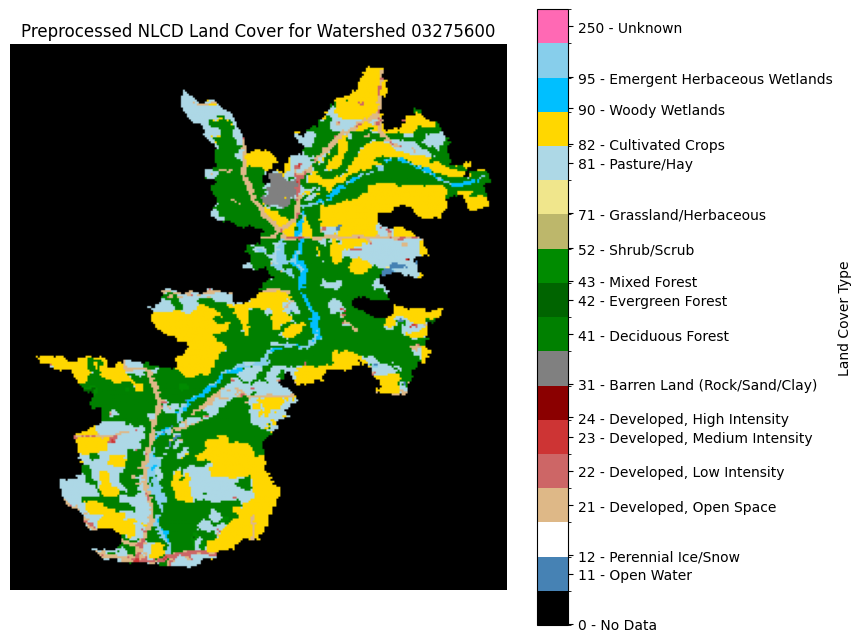

In [ ]:
NLCD_CLASSES = {
    250: 'Unknown',
    0: 'No Data',
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

# Define colors for NLCD classes (RGB values normalized to [0, 1])
nlcd_colors = {
    0: (0/255, 0/255, 0/255),          # No Data - black
    11: (70/255, 130/255, 180/255),    # Open Water - blue
    12: (255/255, 255/255, 255/255),   # Perennial Ice/Snow - white
    21: (222/255, 184/255, 135/255),   # Developed, Open Space - light brown
    22: (205/255, 102/255, 102/255),   # Developed, Low Intensity - light red
    23: (205/255, 52/255, 52/255),     # Developed, Medium Intensity - medium red
    24: (139/255, 0/255, 0/255),       # Developed, High Intensity - dark red
    31: (128/255, 128/255, 128/255),   # Barren Land - gray
    41: (0/255, 128/255, 0/255),       # Deciduous Forest - green
    42: (0/255, 100/255, 0/255),       # Evergreen Forest - dark green
    43: (0/255, 139/255, 0/255),       # Mixed Forest - medium green
    52: (189/255, 183/255, 107/255),   # Shrub/Scrub - olive
    71: (240/255, 230/255, 140/255),   # Grassland/Herbaceous - light yellow-green
    81: (173/255, 216/255, 230/255),   # Pasture/Hay - light blue-green
    82: (255/255, 215/255, 0/255),     # Cultivated Crops - yellow
    90: (0/255, 191/255, 255/255),     # Woody Wetlands - cyan
    95: (135/255, 206/255, 235/255),   # Emergent Herbaceous Wetlands - light cyan
    250: (255/255, 105/255, 180/255)   # Unknown - pink
}

def plot_landcover(landcover_array, title="Preprocessed NLCD Land Cover"):
    """
    Plot the preprocessed NLCD land cover raster.

    Parameters:
    -----------
    landcover_array : np.ndarray
        Preprocessed NLCD raster array in memory.
    title : str
        Title of the plot.
    """
    # Get sorted list of NLCD class codes
    sorted_classes = sorted(NLCD_CLASSES.keys())
    
    # Create list of colors in the same order
    colors_list = [nlcd_colors[cls] for cls in sorted_classes]
    
    # Create custom colormap
    cmap = mcolors.ListedColormap(colors_list)
    
    # Define boundaries for discrete classes
    boundaries = [cls - 0.5 for cls in sorted_classes] + [sorted_classes[-1] + 0.5]
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)
    
    # Set up the plot
    plt.figure(figsize=(8, 8))
    im = plt.imshow(landcover_array, cmap=cmap, norm=norm)
    plt.title(title)
    
    # Customize the colorbar
    cbar = plt.colorbar(im, ticks=sorted_classes)
    cbar.ax.set_yticklabels([f"{cls} - {NLCD_CLASSES[cls]}" for cls in sorted_classes])
    cbar.set_label('Land Cover Type')
    
    plt.axis('off')
    plt.show()
plot_landcover(data, title=f"Preprocessed NLCD Land Cover for Watershed {cleaned_ws['stnid'].iloc[0]}")

#### Batch Process

In [65]:
ws_cleaned_dir = project_root_path / 'data/gold/geo/gpkg/watersheds'
ws_cleaned_file_path = list(ws_cleaned_dir.glob('*.gpkg'))
print(f'Number of cleaned delineated watersheds: {len(ws_cleaned_file_path)}')

Number of cleaned delineated watersheds: 529


In [87]:
nlcd_dir = project_root_path / 'data/bronze/geo/raster/Annual_NLCD_LndCov_2015-2023_CU_C1V0'
nlcd_dir_out = project_root_path / 'data/gold/geo/raster/Annual_NLCD_LndCov_2015-2023_CU_C1V0'
fdir_dir = project_root_path / 'data/silver/geo/raster/watersheds/'
nlcd_dir_out.mkdir(parents=True, exist_ok=True)

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

for year in years:
    nlcd_path = nlcd_dir / f'Annual_NLCD_LndCov_{year}_CU_C1V0.tif'
    
    if not nlcd_path.exists():
        print(f'NLCD file for {year} does not exist, skipping.')
        continue
    
    # Preprocess NLCD raster for each watershed
    for ws_path in tqdm(ws_cleaned_file_path, desc=f'Processing NLCD for {year}'):
        ws_gdf = gpd.read_file(ws_path)
        stnid = ws_gdf['stnid'].iloc[0]
        
        # Define output path
        nlcd_out_path = nlcd_dir_out / f'LndCov_{year}_catchment_{stnid}.tif'
        
        # Get resolution in meters
        fdir_path = fdir_dir /f'flowdir_{stnid}.tif'

        with rasterio.open(fdir_path) as src:
            res  = src.res
            raster_crs = src.crs

        target_crs = ws_gdf.crs
        lonlat = ws_gdf.to_crs(raster_crs).geometry.centroid
        lon, lat = lonlat.x.iloc[0], lonlat.y.iloc[0]
        res_meters  = gmc.degree_res_to_meter_res(res, lon, lat, raster_crs, target_crs)
    
        # Preprocess and save the NLCD raster
        _, _ = gmc.preprocess_mrlc(nlcd_path, ws_gdf, res_meters, output_path=nlcd_out_path)

        gc.collect()


Processing NLCD for 2015:   0%|          | 0/529 [00:00<?, ?it/s]

Processing NLCD for 2016:   0%|          | 0/529 [00:00<?, ?it/s]

Processing NLCD for 2017:   0%|          | 0/529 [00:00<?, ?it/s]

Processing NLCD for 2018:   0%|          | 0/529 [00:00<?, ?it/s]

Processing NLCD for 2019:   0%|          | 0/529 [00:00<?, ?it/s]

Processing NLCD for 2020:   0%|          | 0/529 [00:00<?, ?it/s]

Processing NLCD for 2021:   0%|          | 0/529 [00:00<?, ?it/s]

Processing NLCD for 2022:   0%|          | 0/529 [00:00<?, ?it/s]

Processing NLCD for 2023:   0%|          | 0/529 [00:00<?, ?it/s]

In [90]:
count_nlcd = nlcd_dir_out.glob('*.tif')
print(f'Number of preprocessed NLCD rasters: {len(list(count_nlcd))}')

Number of preprocessed NLCD rasters: 4761


#### Extract streams from DEM


In [147]:
from pysheds.grid import Grid
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns


In [188]:
# Define paths
flowdir_dir = project_root_path / 'data/silver/geo/raster/watersheds'
valid_wsb_path = project_root_path / 'data/silver/tabular/other/valid_watersheds.csv'
valid_wsb = pd.read_csv(valid_wsb_path, dtype={'stnid': 'object'})['stnid']
stnid = valid_wsb.iloc[random.randint(0, len(valid_wsb)-1)]
fdir_path = str(flowdir_dir / f'flowdir_{stnid}.tif')
catch_path = str(flowdir_dir / f'catchment_{stnid}.tif')

In [189]:
# Load the flow direction raster
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
grid = Grid.from_raster(fdir_path, data_name='flowdir')
fdir = grid.read_raster(fdir_path, data_name='flowdir', metadata={'dirmap':dirmap, 'routing':'d8'})
catch_mask = grid.read_raster(catch_path, data_name='catchment')
catch_mask

Raster([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], shape=(108, 173), dtype=int32)

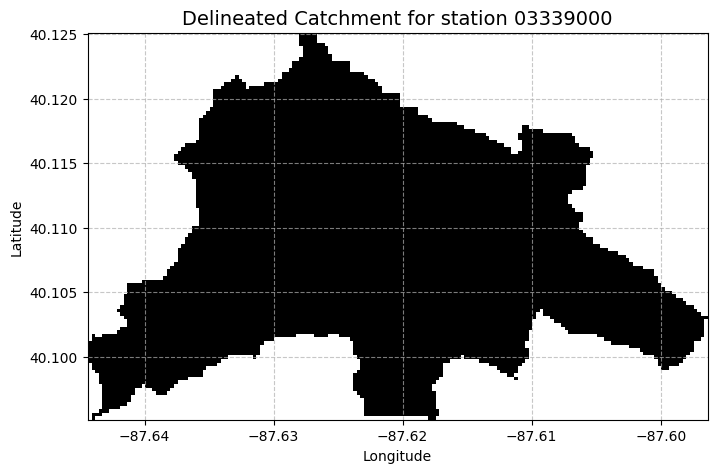

In [193]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid(True, linestyle = '--', zorder=0, alpha = 0.7)
im = ax.imshow(np.where(catch_mask, catch_mask, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Delineated Catchment for station {stnid}', size=14)
plt.show()

In [191]:
grid.clip_to(catch_mask)
fdir

Raster([[  2,   2,   2, ...,   1,   1,  -2],
        [  4,   1,   1, ...,   1, 128,  64],
        [  1, 128, 128, ...,   1, 128,  64],
        ...,
        [ 64,  64,  64, ...,  16,  16,   8],
        [  4,   4,   4, ...,  16,  16,  16],
        [ -2,   1,   1, ...,  16,  16,  64]],
       shape=(973, 973), dtype=int32)

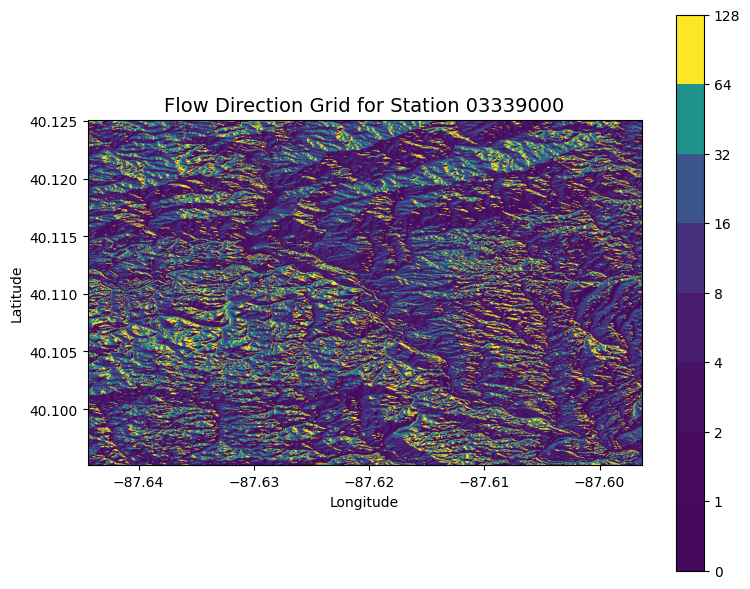

In [192]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Flow Direction Grid for Station {stnid}', size=14)
plt.grid(zorder=-1)
plt.tight_layout()
plt.show()

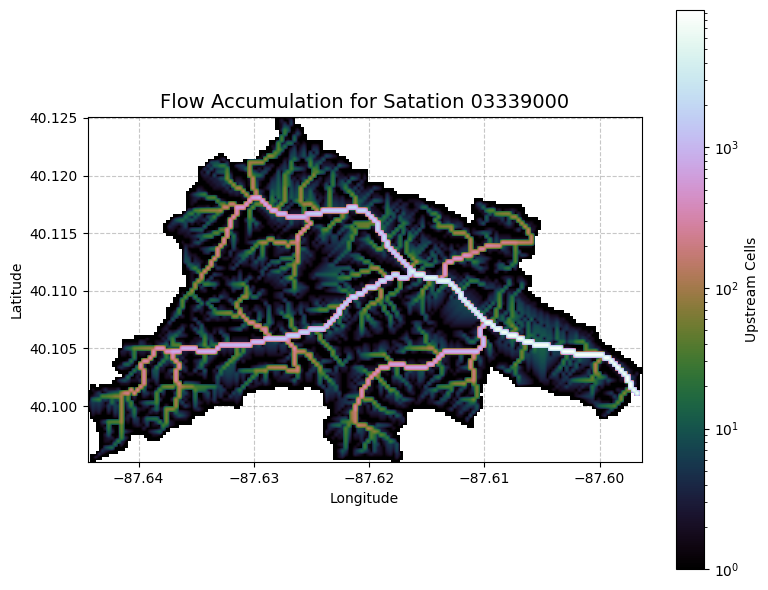

In [195]:
# Compute accumulation
acc = grid.accumulation(fdir, dirmap=dirmap)

# Plot flow accumulation
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid(True, linestyle='--', zorder=0, alpha=0.7)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title(f'Flow Accumulation for Satation {stnid}', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

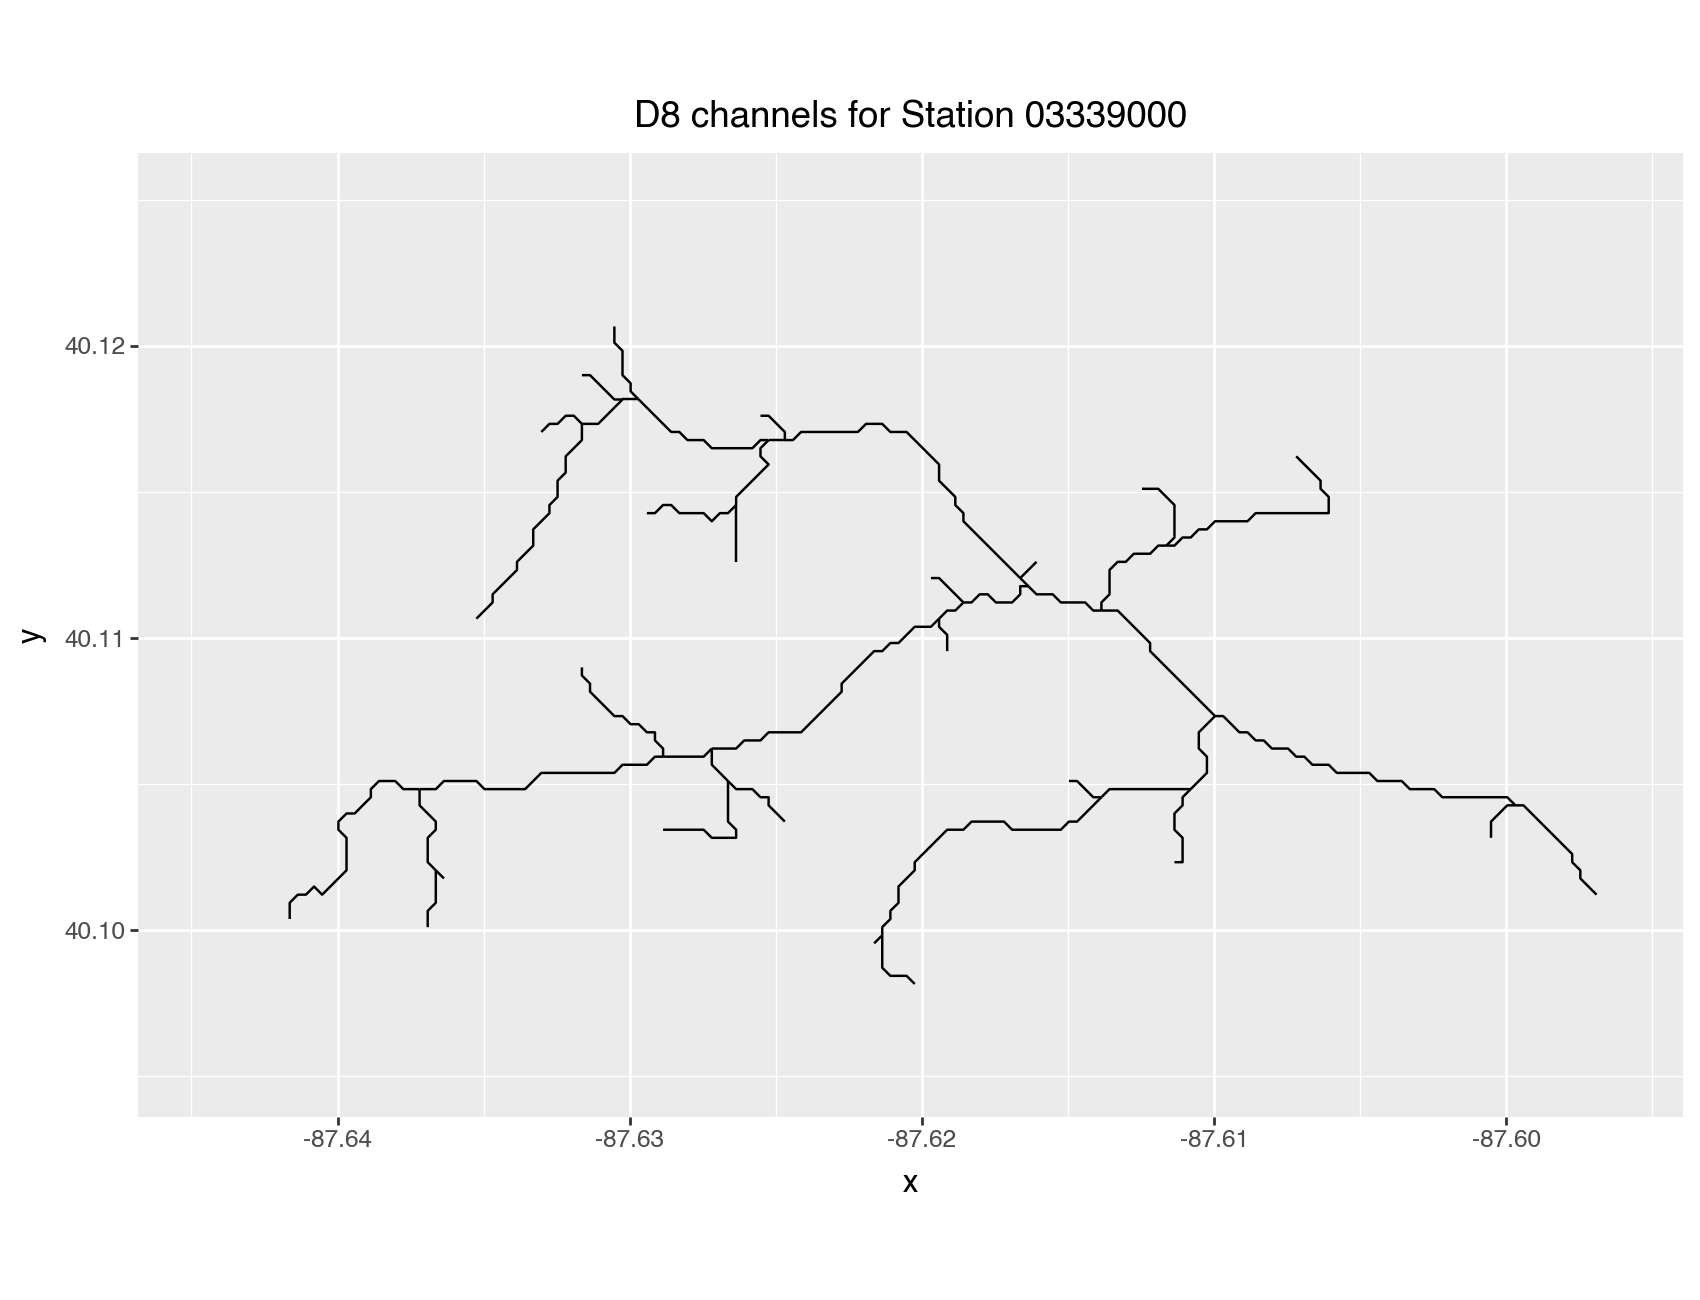

In [201]:
from plotnine import *
import pandas as pd
import numpy as np

# Extract branches (assuming grid, fdir, acc, dirmap, and stnid are defined)
branches = grid.extract_river_network(fdir, acc > 100, dirmap=dirmap)

# Prepare data for plotnine
data = []
for i, branch in enumerate(branches['features']):
    line = np.asarray(branch['geometry']['coordinates'])
    for x, y in line:
        data.append({'x': x, 'y': y, 'branch_id': i})

df = pd.DataFrame(data)

# Create the plot
p = (ggplot(df, aes(x='x', y='y', group='branch_id'))
     + geom_path()  # Plot lines for each branch
     + coord_fixed(ratio=1)  # Equal aspect ratio
     + xlim(grid.bbox[0], grid.bbox[2])  # Set x limits
     + ylim(grid.bbox[1], grid.bbox[3])  # Set y limits
     + ggtitle(f'D8 channels for Station {stnid}')  # Title
     + theme(figure_size=(8.5, 6.5))  # Figure size
)

# Display the plot
p.show()

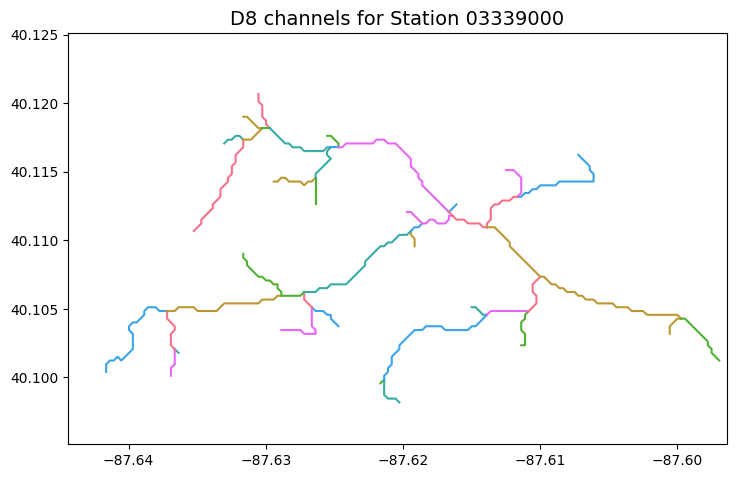

In [198]:
# Extract Branches
branches = grid.extract_river_network(fdir, acc > 100, dirmap=dirmap)
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title(f'D8 channels for Station {stnid}', size=14)
plt.show()

In [128]:
lc_perc = gmc.compute_land_cover_percentages(data, False)
print(f"Land cover percentages for watershed {cleaned_ws['stnid'].iloc[0]}:")
lc_perc

Land cover percentages for watershed 03275600:


{'lc_code_11': np.float64(0.27717368129290865),
 'lc_code_21': np.float64(4.818557844015181),
 'lc_code_22': np.float64(1.1811863033559336),
 'lc_code_23': np.float64(0.08954842011001664),
 'lc_code_24': np.float64(0.0042642104814293634),
 'lc_code_31': np.float64(0.8869557801373076),
 'lc_code_41': np.float64(40.693360624280416),
 'lc_code_42': np.float64(0.06822736770286982),
 'lc_code_43': np.float64(0.656688414140122),
 'lc_code_71': np.float64(0.021321052407146816),
 'lc_code_81': np.float64(19.09513453584069),
 'lc_code_82': np.float64(28.561681804613876),
 'lc_code_90': np.float64(1.5777578781288646),
 'lc_code_95': np.float64(2.0681420834932416)}